In [2]:
from skimage import io,filters
import cv2 as cv
import numpy as np

In [3]:
path = './result_skeletonized.tif'

In [4]:
img = io.imread(path)
img = (np.array(img) - np.min(img)) / (np.max(img) - np.min(img))

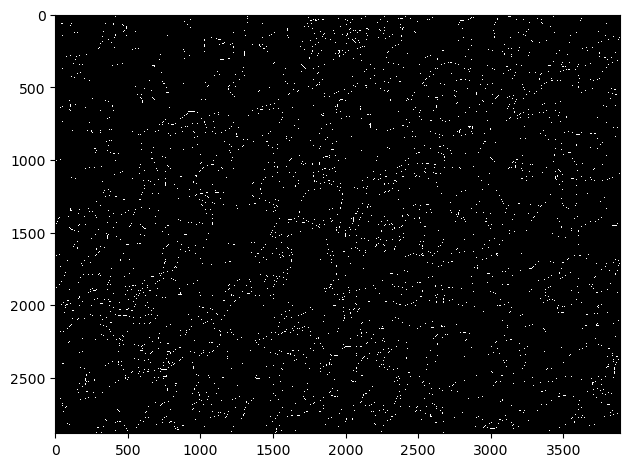

In [5]:
io.imshow(img)

In [6]:
# Function that calculates the elements Jxx, Jxy and Jyy of the structure tensor matrix
def structure_tensor(img, sigma):
    # Initialize output vatiables
    Jxx = np.zeros(img.shape)
    Jxy = np.zeros(img.shape)
    Jyy = np.zeros(img.shape)
        
    # Calculate the first order derivatives w.r.t x and y
    fx = cv.Sobel(src=img, ddepth=cv.CV_64F, dx=1, dy=0, ksize=3)
    fy = cv.Sobel(src=img, ddepth=cv.CV_64F, dx=0, dy=1, ksize=3)

    # The elements of the structure tensor are Gaussian blurred
    # squared derivatives. (Note: by default, sigmaY has the same value as sigmaX)
    Jxx = cv.GaussianBlur(src=fx**2, ksize=(0,0), sigmaX=sigma)
    Jxy = cv.GaussianBlur(src=fx*fy, ksize=(0,0), sigmaX=sigma)
    Jyy = cv.GaussianBlur(src=fy**2, ksize=(0,0), sigmaX=sigma)
    
    return Jxx, Jxy, Jyy

In [7]:
# Function that calculates the orientation features of an image for a given sigma
def orientation_features(img, sigma):
    orientation = np.zeros(img.shape)
    energy      = np.zeros(img.shape)
    coherence   = np.zeros(img.shape)
    harris      = np.zeros(img.shape)
        
    # Structure tensor
    Jxx, Jxy, Jyy = structure_tensor(img, sigma=sigma)
    
    # Orientation features
    orientation = 0.5*np.arctan2(2*Jxy, Jyy-Jxx)
    energy = Jyy + Jxx
    
    # Because J is a 2D matrix, 
    # det(J)=Jxx*Jyy-Jxy*Jxy,
    # and trace(J) = Jxx+Jyy
    harris = Jxx*Jyy - Jxy*Jxy - 0.05*(Jxx+Jyy)**2
    
    # To calculate coherence, divide by (Jyy+Jxx+epsilon) to avoid division by 0
    coherence = np.sqrt( (Jyy - Jxx)**2 + 4*Jxy**2 ) / (Jyy + Jxx + np.finfo(float).eps)
    # Set the coherence on locations where (Jyy + Jxx)<0.01 to 0.
    coherence[np.where((Jyy + Jxx)<0.01)] = 0
    
    return orientation, energy, coherence, harris

In [8]:
# Function that returns a colorized rgb image depending on the orientation features
def colorize_features(orientation, coherence, img, mode):
    # Fill hsv_img[:,:,0] to set the hue, hsv_img[:,:,1] to set the saturation, and hsv_img[:,:,2] to set the value
    hsv_img = np.zeros((img.shape[0], img.shape[1], 3), dtype = np.uint8)
    rgb_img = np.zeros((img.shape[0], img.shape[1], 3), dtype = np.uint8)
    
    # YOUR CODE HERE
    
    # Fill H channel with orientation (same for both modes). 
    hsv_img[:,:,0] = 180*(orientation + np.pi/2) / np.pi  # Rescale (range [-pi/2,pi/2] -> range [0,180])
    
    # Fill S and V channels (different for the 2 modes)
    if (mode==0):
        hsv_img[:,:,1] = 255
        hsv_img[:,:,2] = 255
    elif (mode==1):
        hsv_img[:,:,1] = 255*coherence  # Rescale (range [0,1] -> range [0,255]
        hsv_img[:,:,2] = 255*img             
    else:
        raise ValueError('mode must be either 0 or 1!')
    
    # Convert to RGB for visualization
    rgb_img = cv.cvtColor(hsv_img, cv.COLOR_HSV2RGB)
    
    return rgb_img

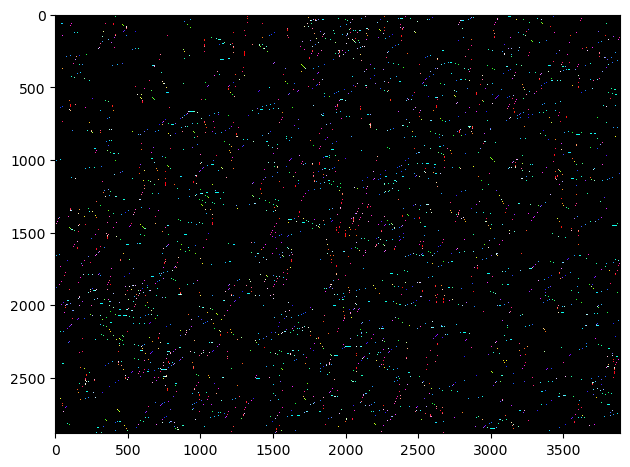

In [11]:
sigma = 5
orientation, energy, coherence, harris = orientation_features(img, sigma=sigma)
dog = filters.difference_of_gaussians(img,low_sigma=sigma, high_sigma=1.6*sigma)
dog_norm = (dog - np.min(dog)) / (np.max(dog - np.min(dog)))
rgb_img = colorize_features(orientation, coherence, img, mode=1)
io.imshow(rgb_img)

io.imsave('result_skeletonized_orientation.tif',rgb_img)

/var/folders/0z/hvg4mzl50gqb0m2ql3c0w0xc0000gn/T/ipykernel_43141/375158685.py:4: UserWarning: result_skeletonized_orientation.tif is a low contrast image
  io.imsave('result_skeletonized_orientation.tif',img*orientation)


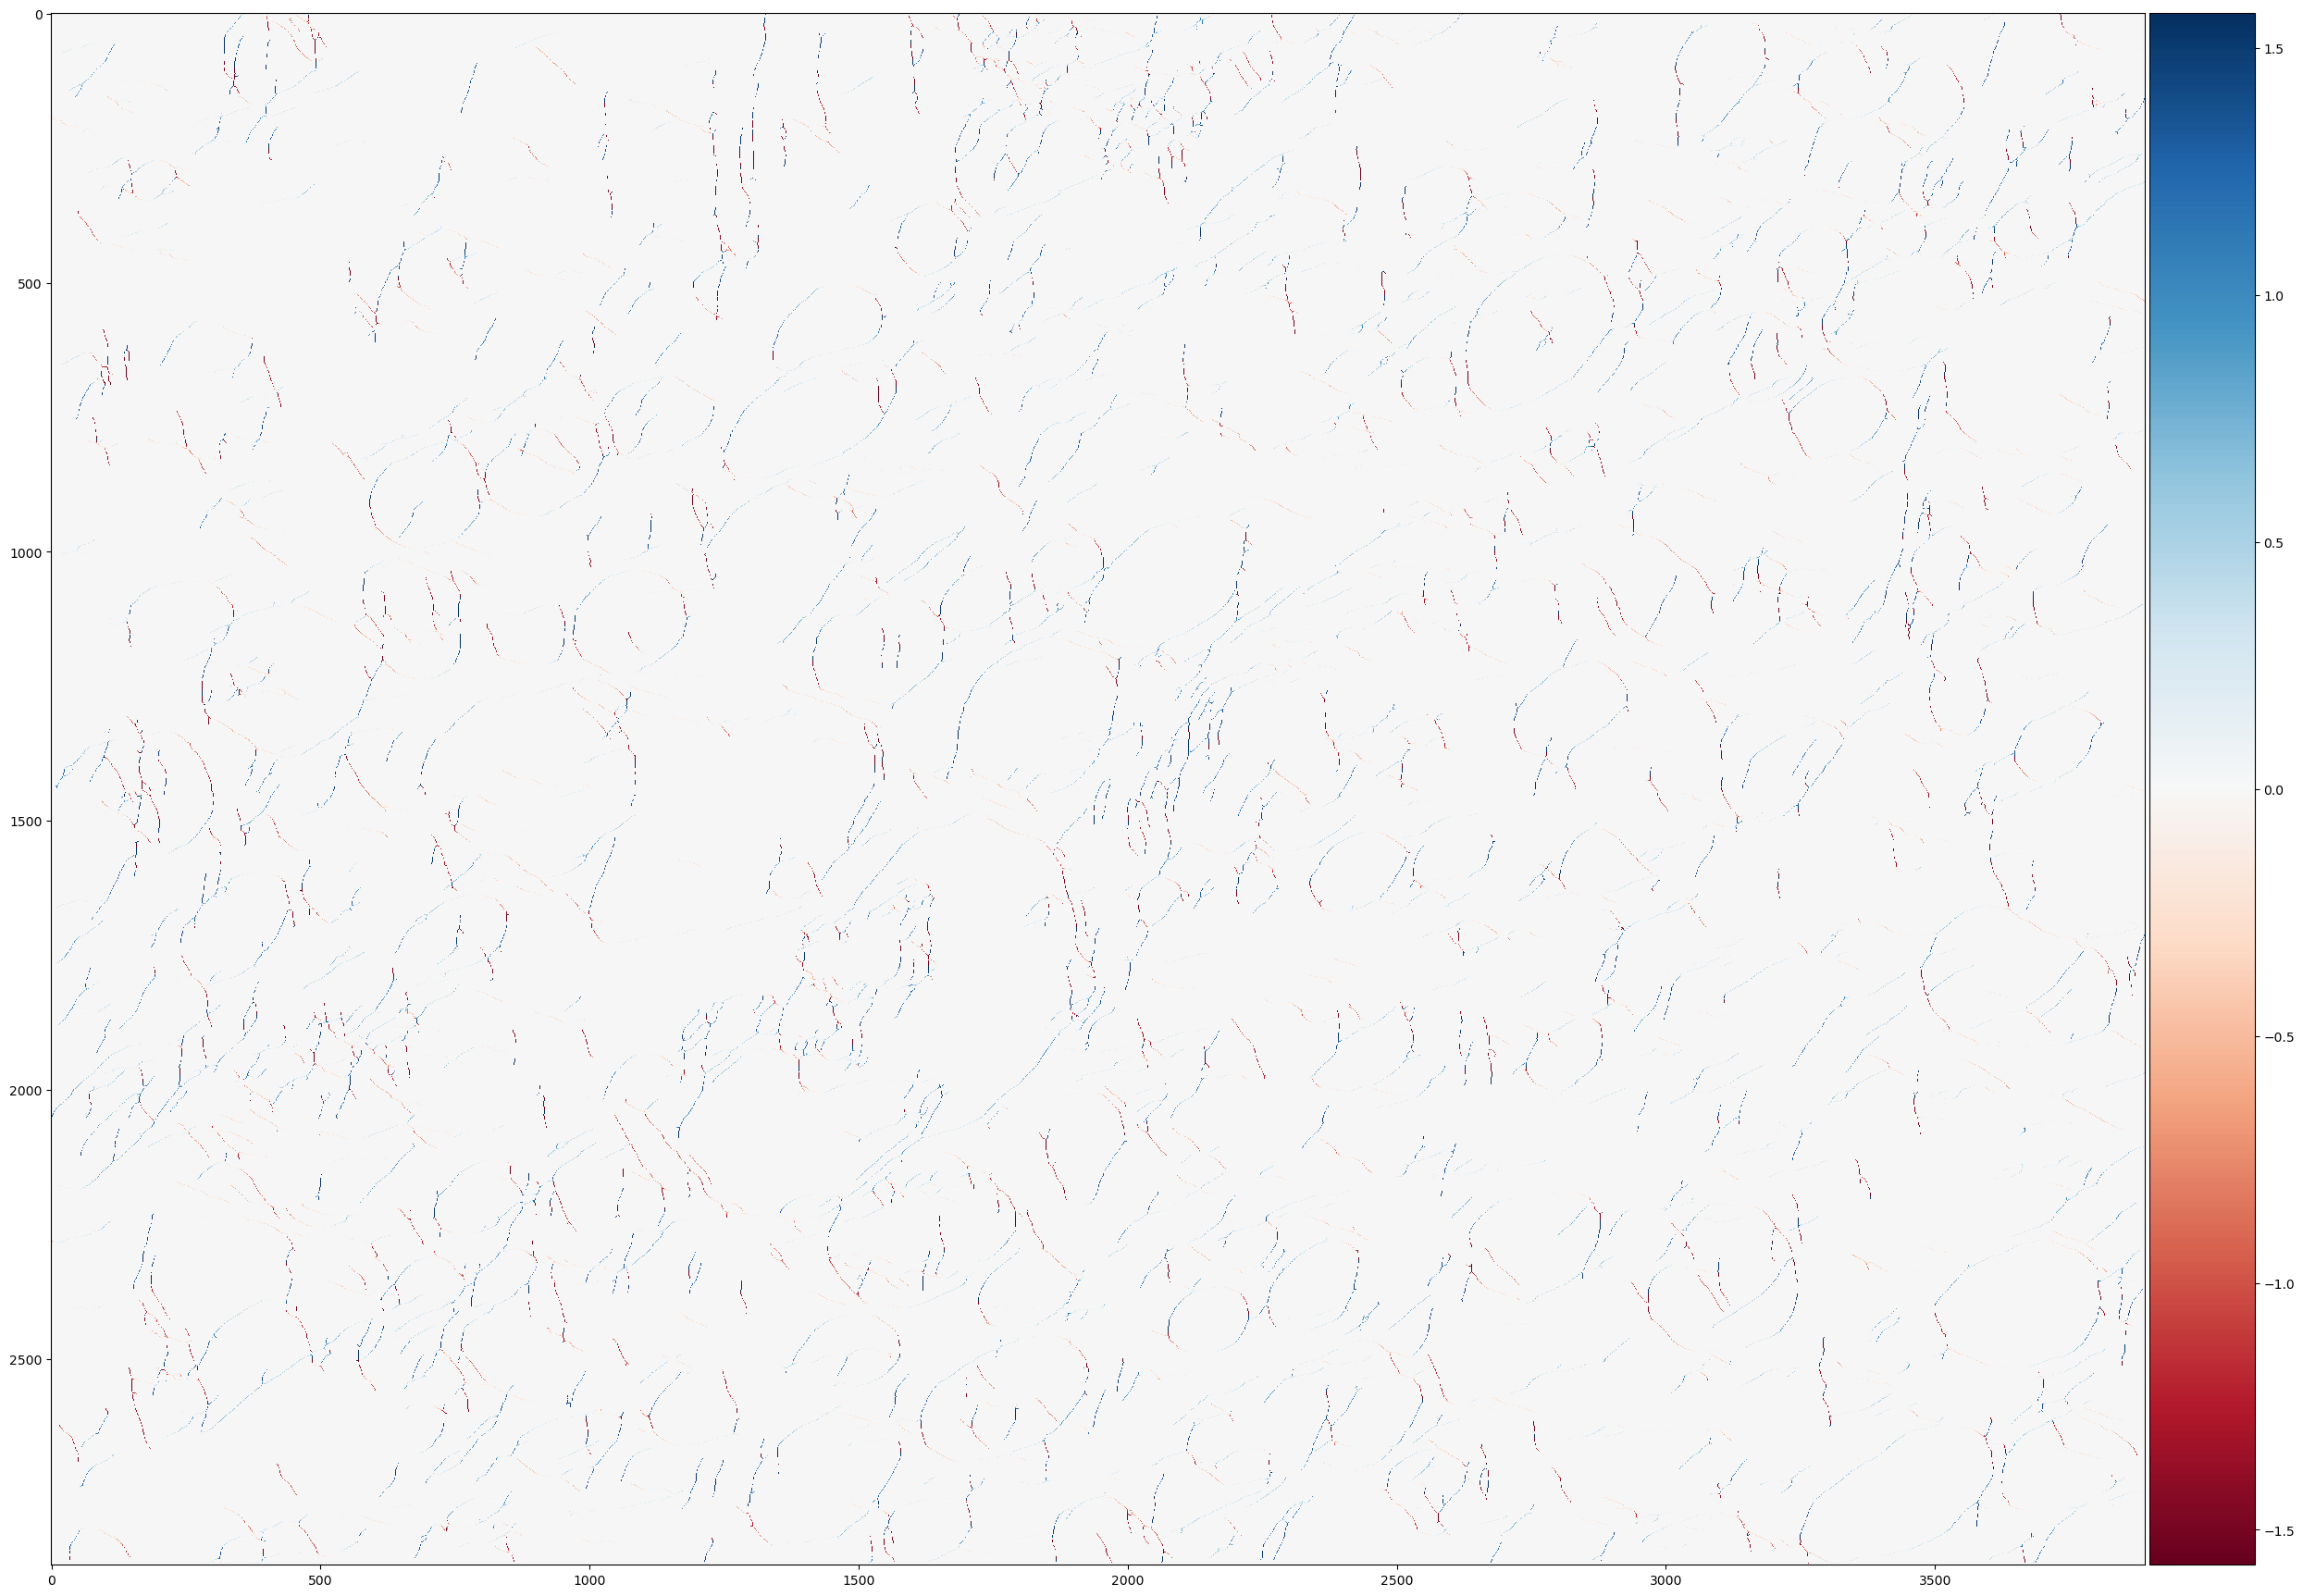

In [16]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(25,25))
io.imshow(img*orientation)
io.imsave('result_skeletonized_orientation.tif',img*orientation)
#io.imsave('LH01_A01_b1_A4_montage2-selection-coherence.tif',coherence)

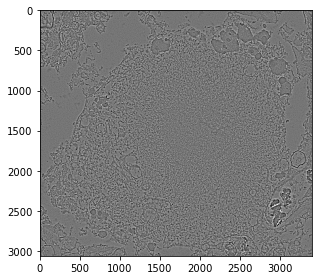

In [30]:
io.imshow(dog_norm)

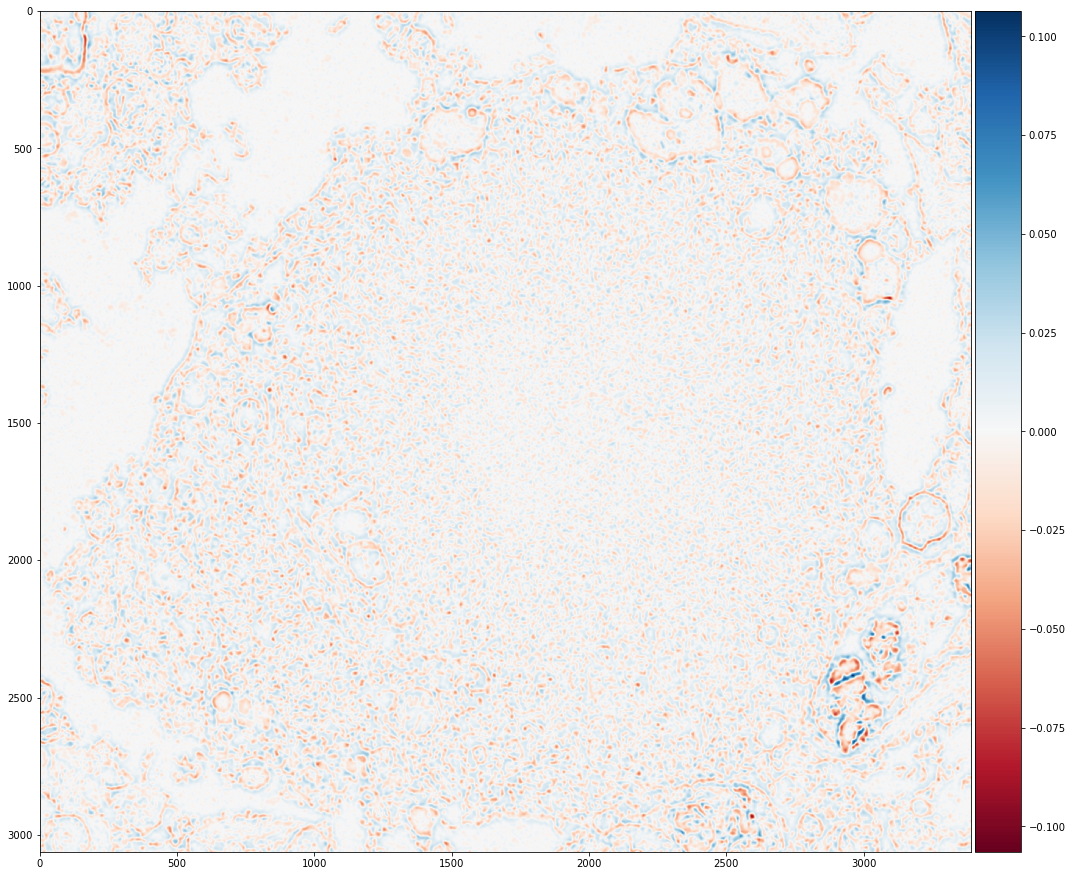

In [26]:
# Laplacian operator
sigma = 5
dog = filters.difference_of_gaussians(img,low_sigma=sigma, high_sigma=1.6*sigma)
fig,ax = plt.subplots(figsize=(15,15))
io.imshow(dog)